In [ ]:
!pip install dowhy econml openpyxl pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninst

In [ ]:
import pandas as pd
import numpy as np
import os
import json
from econml.dr import DRLearner
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer # Added FunctionTransformer import
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
# STEP 3: Upload dataset
# =====================================
from google.colab import files
uploaded = files.upload()

Saving dataset MUFG hacakthonxlsx.xlsx to dataset MUFG hacakthonxlsx.xlsx


In [ ]:
# Replace with your uploaded filename
data_path = list(uploaded.keys())[0]
print("Uploaded file:", data_path)

Uploaded file: dataset MUFG hacakthonxlsx.xlsx


In [ ]:
# ==== STEP 1: Upload your Excel file
print("/content/dataset MUFG hacakthonxlsx.xlsx")
# uploaded = files.upload() # File already uploaded in previous step
DATA_PATH = list(uploaded.keys())[0]
SHEET_NAME = "australia_insurance_extended_mo" # set to sheet name if needed, else first sheet

/content/dataset MUFG hacakthonxlsx.xlsx


In [ ]:
# ==== STEP 0: Setup
!pip install --quiet pandas numpy scikit-learn openpyxl

import os, json, re, math, numpy as np, pandas as pd
from google.colab import files

from typing import List, Dict, Any, Tuple

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

In [ ]:
# ==== STEP 2: Configuration (you can edit)
TARGET_COL = "claim status"  # if known, set the exact col name here; else auto-detect
# Turn this on to also create binary "pseudo-treatments" from numeric features via median split
ALLOW_NUMERIC_BINNING = True
# For multiclass categoricals, create one-vs-rest binaries when unique values <= this
MAX_CATS_FOR_OVR = 5
# Max number of treatments to estimate (keeps runtime reasonable)
MAX_TREATMENTS = 20
# Bootstrap samples for 95% CI
BOOT_SAMPLES = 300
RANDOM_SEED = 42

# Tokens to map target & binary-like columns
APPROVE_TOKENS = {"yes","y","true","1","approved","approve","accept","accepted","pass","eligible"}
REJECT_TOKENS  = {"no","n","false","0","rejected","reject","deny","denied","fail","ineligible"}

In [ ]:
# ==== STEP 3: Load & normalize
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w]", "", regex=True)
        .str.lower()
    )
    return df

def load_excel(path: str, sheet_name=None) -> pd.DataFrame:
    if sheet_name is None:
        xls = pd.ExcelFile(path)
        sheet_name = xls.sheet_names[0]
    df = pd.read_excel(path, sheet_name=sheet_name)
    return normalize_columns(df)

df = load_excel(DATA_PATH, sheet_name=SHEET_NAME)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:50])

Loaded shape: (1000, 16)
Columns: ['customer_name', 'age', 'state', 'insurance_type', 'annual_premium_aud', 'claim_amount_aud', 'claim_status', 'policy_start_date', 'policy_end_date', 'policy_number', 'product_tier', 'payment_frequency', 'risk_score', 'email', 'phone', 'agent_name']


In [ ]:
xls = pd.ExcelFile(DATA_PATH)
print("Available sheets:", xls.sheet_names)

Available sheets: ['australia_insurance_extended_mo']


In [ ]:
# ==== STEP 4: Find/confirm target column (approval/rejection)
def find_target(df: pd.DataFrame, user_target: str | None) -> str | None:
    if user_target and user_target in df.columns:
        return user_target
    patterns = [
        r"^policy_status$", r"^status$", r"^approval_status$", r"^decision$",
        r"^approved$", r"^is_approved$", r"^result$", r"^outcome$",
        r".*approve.*", r".*reject.*", r".*decision.*", r".*status.*"
    ]
    for pat in patterns:
        for c in df.columns:
            if re.match(pat, c):
                return c
    return None

def map_to_binary(series: pd.Series) -> pd.Series:
    vals = []
    for v in series:
        if pd.isna(v):
            vals.append(np.nan)
            continue
        s = str(v).strip().lower()
        if s in APPROVE_TOKENS:
            vals.append(1)
        elif s in REJECT_TOKENS:
            vals.append(0)
        else:
            # numeric fallback
            try:
                f = float(s)
                if f == 1.0: vals.append(1)
                elif f == 0.0: vals.append(0)
                else: vals.append(np.nan)
            except:
                vals.append(np.nan)
    return pd.Series(vals, index=series.index)

tgt = find_target(df, TARGET_COL)
if tgt is None:
    # show a peek so you can set TARGET_COL above
    display(df.head(3))
    raise ValueError(
        "❗ Could not automatically detect the approval/rejection target column.\n"
        "Please set TARGET_COL above (e.g., 'policy_status', 'approval_status', 'status', 'decision')."
    )

y = map_to_binary(df[tgt])
# last fallback if many NaN and it's already 0/1 numeric
if y.notna().mean() < 0.5:
    try:
        yn = pd.to_numeric(df[tgt], errors="coerce")
        if set(pd.unique(yn.dropna())) <= {0,1}:
            y = yn
    except:
        pass

print(f"Target column: {tgt}")
print("Target distribution (after mapping):")
print(y.value_counts(dropna=False))

Target column: claim_status
Target distribution (after mapping):
1.0    621
NaN    198
0.0    181
Name: count, dtype: int64


In [ ]:
# ==== STEP 5: Build robust binary treatment candidates
def is_numeric(s: pd.Series) -> bool:
    return pd.api.types.is_numeric_dtype(s)

def detect_binary_like(series: pd.Series) -> Tuple[bool, pd.Series | None]:
    """Return (is_binary, mapped_series_0_1_or_None)."""
    s = series.copy()
    # direct binary numeric
    if is_numeric(s) and s.dropna().nunique() == 2:
        uniq = set(pd.unique(s.dropna()))
        if uniq <= {0,1}:
            return True, s.astype("Int64")
    # token mapping
    mapped = s.astype(str).str.strip().str.lower().map(
        {**{k:1 for k in APPROVE_TOKENS}, **{k:0 for k in REJECT_TOKENS}}
    )
    if mapped.dropna().nunique() == 2:
        return True, mapped.astype("Int64")
    # string two unique values
    if s.dropna().astype(str).str.lower().nunique() == 2:
        # map first sorted to 0, second to 1 (arbitrary but consistent)
        vals = sorted(s.dropna().astype(str).str.lower().unique().tolist())
        map2 = {vals[0]:0, vals[1]:1}
        return True, s.astype(str).str.lower().map(map2).astype("Int64")
    return False, None

def generate_binary_treatments(df: pd.DataFrame, target_name: str) -> Dict[str, pd.Series]:
    treatments: Dict[str, pd.Series] = {}

    # 5.1: existing binary-like features
    for c in df.columns:
        if c == target_name:
            continue
        ok, mapped = detect_binary_like(df[c])
        if ok:
            treatments[c] = mapped

    # 5.2: one-vs-rest for small-cardinality categoricals (<= MAX_CATS_FOR_OVR)
    for c in df.columns:
        if c == target_name or is_numeric(df[c]):
            continue
        uniq = df[c].dropna().astype(str).str.strip().str.lower().unique()
        if 2 < len(uniq) <= MAX_CATS_FOR_OVR:
            # create binaries for each category that has at least, say, 5% support
            vc = df[c].astype(str).str.strip().str.lower().value_counts(normalize=True)
            cats = [k for k,v in vc.items() if v >= 0.05]
            for cat in cats[:MAX_CATS_FOR_OVR]:
                name = f"{c}__is__{cat}"
                treatments[name] = (df[c].astype(str).str.strip().str.lower() == cat).astype("Int64")

    # 5.3: optional numeric binning (median split) -> pseudo-treatments
    if ALLOW_NUMERIC_BINNING:
        for c in df.columns:
            if c == target_name:
                continue
            s = df[c]
            if is_numeric(s):
                s2 = pd.to_numeric(s, errors="coerce")
                if s2.notna().sum() >= 50 and s2.dropna().nunique() >= 5:
                    thr = s2.median()
                    name = f"{c}__high_vs_low_med"
                    treatments[name] = (s2 > thr).astype("Int64")

    return treatments

treatments = generate_binary_treatments(df, tgt)
print(f"Found {len(treatments)} binary treatment candidates (including OVR & optional numeric bins).")
if not treatments:
    # show column uniques to help you tweak settings
    overview = []
    for c in df.columns:
        vals = df[c].dropna().astype(str).str.lower().unique().tolist()
        overview.append((c, len(vals), vals[:8]))
    ov = pd.DataFrame(overview, columns=["column","nunique","sample_values"])
    display(ov.sort_values("nunique"))
    raise ValueError("❗ No treatments found. Consider lowering MAX_CATS_FOR_OVR or enabling ALLOW_NUMERIC_BINNING.")

Found 16 binary treatment candidates (including OVR & optional numeric bins).


In [ ]:
# ==== STEP 6: Preprocessing for confounders (X)
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    num_cols = [c for c in X.columns if is_numeric(X[c])]
    cat_cols = [c for c in X.columns if c not in num_cols]
    num_pipe = Pipeline([("impute", SimpleImputer(strategy="median"))])
    cat_pipe = Pipeline([
        ("to_string", FunctionTransformer(lambda x: x.astype(str))), # Added step to convert to string
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])
    return ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ])

def prepare_X(df: pd.DataFrame, drop_cols: List[str]) -> pd.DataFrame:
    return df.drop(columns=drop_cols, errors="ignore").copy()

In [ ]:
# ==== STEP 7: AIPW/DR estimator for binary treatment & binary outcome
def dr_ate_binary(df: pd.DataFrame, y: pd.Series, T: pd.Series, drop_cols: List[str],
                  boot_samples: int = 300, seed: int = 42) -> Dict[str, Any]:
    # mask complete cases
    mask = y.notna() & T.notna()
    y_ = y.loc[mask].astype(int)
    T_ = T.loc[mask].astype(int)
    X_raw = prepare_X(df.loc[mask], drop_cols=drop_cols)

    if len(X_raw) < 100 or y_.nunique() < 2 or T_.nunique() < 2:
        return {"ok": False, "reason": "insufficient variation or rows"}

    pre_X = build_preprocessor(X_raw)

    # Propensity e(X)=P(T=1|X)
    prop = Pipeline([("pre", pre_X),
                     ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))])
    prop.fit(X_raw, T_)
    e = prop.predict_proba(X_raw)[:,1]
    e = np.clip(e, 1e-3, 1-1e-3)

    # Outcome models m1(X), m0(X)
    m1 = Pipeline([("pre", pre_X),
                   ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
    if (T_==1).sum() >= 20 and y_[T_==1].nunique() > 1:
        m1.fit(X_raw[T_==1], y_[T_==1])
        mu1 = m1.predict_proba(X_raw)[:,1]
    else:
        mu1 = np.full(len(X_raw), y_[T_==1].mean() if (T_==1).sum()>0 else y_.mean())

    m0 = Pipeline([("pre", pre_X),
                   ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
    if (T_==0).sum() >= 20 and y_[T_==0].nunique() > 1:
        m0.fit(X_raw[T_==0], y_[T_==0])
        mu0 = m0.predict_proba(X_raw)[:,1]
    else:
        mu0 = np.full(len(X_raw), y_[T_==0].mean() if (T_==0).sum()>0 else y_.mean())

    # AIPW pseudo-outcome
    tau_hat = (mu1 - mu0) + (T_*(y_ - mu1)/e) - ((1-T_)*(y_ - mu0)/(1-e))
    ate = float(np.mean(tau_hat))

    # Bootstrap CI
    rng = np.random.default_rng(seed)
    B = boot_samples
    n = len(tau_hat)
    tau_hat_array = tau_hat.values # Convert to numpy array for positional indexing
    boots = [float(np.mean(tau_hat_array[rng.integers(0, n, n)])) for _ in range(B)] # Use array for indexing
    lo, hi = np.percentile(boots, [2.5, 97.5])

    # quick diagnostic
    XT = pd.concat([X_raw.reset_index(drop=True), T_.rename("t").reset_index(drop=True)], axis=1)
    pre_XT = build_preprocessor(XT)
    diag = Pipeline([("pre", pre_XT),
                     ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
    try:
        diag.fit(XT, y_)
        auc = roc_auc_score(y_, diag.predict_proba(XT)[:,1])
    except Exception:
        auc = float("nan")

    return {
        "ok": True,
        "n": int(n),
        "ate": ate,
        "ci_low": float(lo),
        "ci_high": float(hi),
        "propensity_mean": float(np.mean(e)),
        "outcome_diag_auc": float(auc),
        "treated_rate": float(T_.mean()),
        "base_approval_rate": float(y_.mean()),
    }

In [ ]:
# ==== STEP 8: Run effects for top-N treatments
all_treatments = list(treatments.items())
# de-duplicate by identical series to avoid repeats (hash by tuple of values with NaN as -1)
def _sig(s: pd.Series) -> tuple:
    arr = s.astype("float").values.copy()
    arr = np.where(np.isnan(arr), -1, arr)
    return tuple(arr.tolist())

seen = set()
unique_trts = []
for name, ser in all_treatments:
    sig = _sig(ser)
    if sig not in seen:
        seen.add(sig)
        unique_trts.append((name, ser))
print(f"Using {len(unique_trts)} unique treatments (pre-limit).")

unique_trts = unique_trts[:MAX_TREATMENTS]
print("Final treatment names:", [n for n,_ in unique_trts])

results = []
for name, Tser in unique_trts:
    res = dr_ate_binary(df, y, Tser, drop_cols=[tgt, name],
                        boot_samples=BOOT_SAMPLES, seed=RANDOM_SEED)
    res_row = {"treatment": name, **res}
    results.append(res_row)

results_df = pd.DataFrame(results)
# Filter ok rows and sort by |ATE|
ok_df = results_df[results_df["ok"] == True].copy()
if not ok_df.empty:
    ok_df["abs_ate"] = ok_df["ate"].abs()
    ok_df = ok_df.sort_values("abs_ate", ascending=False).drop(columns=["abs_ate"])
    display(ok_df)
else:
    print("⚠️ No valid ATE results computed. Check treatments or target mapping.")

Using 16 unique treatments (pre-limit).
Final treatment names: ['insurance_type__is__life', 'insurance_type__is__travel', 'insurance_type__is__home', 'insurance_type__is__health', 'insurance_type__is__car', 'product_tier__is__basic', 'product_tier__is__premium', 'product_tier__is__standard', 'product_tier__is__gold', 'payment_frequency__is__monthly', 'payment_frequency__is__annually', 'payment_frequency__is__quarterly', 'age__high_vs_low_med', 'annual_premium_aud__high_vs_low_med', 'claim_amount_aud__high_vs_low_med', 'risk_score__high_vs_low_med']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,treatment,ok,n,ate,ci_low,ci_high,propensity_mean,outcome_diag_auc,treated_rate,base_approval_rate
1,insurance_type__is__travel,True,802,-0.155843,-0.185279,-0.126893,0.216333,1.0,0.206983,0.774314
2,insurance_type__is__home,True,802,-0.143102,-0.175607,-0.108914,0.204491,1.0,0.194514,0.774314
5,product_tier__is__basic,True,802,-0.139957,-0.177197,-0.106890,0.258300,1.0,0.250623,0.774314
11,payment_frequency__is__quarterly,True,802,-0.104894,-0.139813,-0.071798,0.305915,1.0,0.300499,0.774314
7,product_tier__is__standard,True,802,-0.079718,-0.110633,-0.051431,0.260723,1.0,0.253117,0.774314
8,product_tier__is__gold,True,802,-0.076971,-0.109643,-0.045227,0.252173,1.0,0.244389,0.774314
12,age__high_vs_low_med,True,802,-0.063502,-0.093816,-0.028395,0.504359,1.0,0.501247,0.774314
4,insurance_type__is__car,True,802,-0.049450,-0.079162,-0.020928,0.196177,1.0,0.185786,0.774314
15,risk_score__high_vs_low_med,True,802,0.049263,0.016644,0.078876,0.498671,1.0,0.498753,0.774314
3,insurance_type__is__health,True,802,-0.045055,-0.076999,-0.013446,0.208407,1.0,0.198254,0.774314


In [ ]:
# ==== STEP 9: Counterfactuals for strongest treatment
def outcome_model_counterfactuals(df: pd.DataFrame, y: pd.Series, treat_name: str,
                                  sample_n: int = 20) -> Tuple[pd.DataFrame | None, Pipeline | None]: # Modified return type
    Tbin = treatments[treat_name]
    mask = y.notna() & Tbin.notna()
    if mask.sum() < 50:
        return None, None # Modified return

    X_raw = prepare_X(df.loc[mask], drop_cols=[tgt])
    y_ = y.loc[mask].astype(int)
    T_ = Tbin.loc[mask].astype(int)

    pre = build_preprocessor(pd.concat([X_raw, T_.rename("t")], axis=1))
    model = Pipeline([("pre", pre),
                      ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))])
    try:
        model.fit(pd.concat([X_raw, T_.rename("t")], axis=1), y_)
    except Exception as e:
        print("Counterfactual model fit failed:", e)
        return None, None # Modified return

    samp = X_raw.sample(n=min(sample_n, len(X_raw)), random_state=7)
    p1 = model.predict_proba(pd.concat([samp, pd.Series(1, index=samp.index, name="t")], axis=1))[:,1]
    p0 = model.predict_proba(pd.concat([samp, pd.Series(0, index=samp.index, name="t")], axis=1))[:,1]

    cf_df = pd.DataFrame({
        "row_id": samp.index,
        f"p_approve_if_{treat_name}=1": p1,
        f"p_approve_if_{treat_name}=0": p0,
        "delta_prob_1_minus_0": p1 - p0
    })
    return cf_df, model # Modified return

cf_df = None
top_treatment = None
model = None # Initialize model variable
if not ok_df.empty:
    top_treatment = ok_df.iloc[0]["treatment"]
    cf_df, model = outcome_model_counterfactuals(df, y, top_treatment, sample_n=20) # Capture model

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Travel/Home insurance, Basic tier, and Quarterly payments hurt approval; High risk score and High premium improve it.**



In [ ]:
# ==== STEP 10: Save & download outputs
os.makedirs("causal_outputs", exist_ok=True)
summary_path = "causal_outputs/causal_effects_summary.csv"
results_df.to_csv(summary_path, index=False)

meta = {
    "target_col": tgt,
    "treatments_evaluated": [n for n,_ in unique_trts],
    "valid_effects": ok_df[["treatment","ate","ci_low","ci_high","n","treated_rate","base_approval_rate"]].to_dict(orient="records") if not ok_df.empty else [],
    "notes": "ATE via AIPW/DR; 95% CI via bootstrap."
}
with open("causal_outputs/README.json","w") as f:
    json.dump(meta, f, indent=2)

print("📄 Saved:", summary_path)
files.download(summary_path)

if cf_df is not None:
    cf_path = "causal_outputs/counterfactual_demo.csv"
    cf_df.to_csv(cf_path, index=False)
    print("📄 Saved:", cf_path)
    files.download(cf_path)
else:
    print("ℹ️ Counterfactuals not generated (insufficient data or model fit issue).")

# ==== STEP 11: Display the key tables
print("\n=== Causal Effects (all attempts) ===")
display(results_df)

if not ok_df.empty:
    print("\n=== Valid Effects (sorted by |ATE|) ===")
    display(ok_df)

if cf_df is not None:
    print(f"\n=== Counterfactuals for top treatment: {top_treatment} ===")
    display(cf_df.head(20))

📄 Saved: causal_outputs/causal_effects_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📄 Saved: causal_outputs/counterfactual_demo.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Causal Effects (all attempts) ===


,treatment,ok,n,ate,ci_low,ci_high,propensity_mean,outcome_diag_auc,treated_rate,base_approval_rate
0,insurance_type__is__life,True,802,-0.036280,-0.067318,-0.002838,0.223673,1.0,0.214464,0.774314
1,insurance_type__is__travel,True,802,-0.155843,-0.185279,-0.126893,0.216333,1.0,0.206983,0.774314
2,insurance_type__is__home,True,802,-0.143102,-0.175607,-0.108914,0.204491,1.0,0.194514,0.774314
3,insurance_type__is__health,True,802,-0.045055,-0.076999,-0.013446,0.208407,1.0,0.198254,0.774314
4,insurance_type__is__car,True,802,-0.049450,-0.079162,-0.020928,0.196177,1.0,0.185786,0.774314
5,product_tier__is__basic,True,802,-0.139957,-0.177197,-0.106890,0.258300,1.0,0.250623,0.774314
6,product_tier__is__premium,True,802,0.008809,-0.021491,0.042200,0.259435,1.0,0.251870,0.774314
7,product_tier__is__standard,True,802,-0.079718,-0.110633,-0.051431,0.260723,1.0,0.253117,0.774314
8,product_tier__is__gold,True,802,-0.076971,-0.109643,-0.045227,0.252173,1.0,0.244389,0.774314
9,payment_frequency__is__monthly,True,802,-0.027990,-0.063479,0.005034,0.354540,1.0,0.350374,0.774314



=== Valid Effects (sorted by |ATE|) ===


,treatment,ok,n,ate,ci_low,ci_high,propensity_mean,outcome_diag_auc,treated_rate,base_approval_rate
1,insurance_type__is__travel,True,802,-0.155843,-0.185279,-0.126893,0.216333,1.0,0.206983,0.774314
2,insurance_type__is__home,True,802,-0.143102,-0.175607,-0.108914,0.204491,1.0,0.194514,0.774314
5,product_tier__is__basic,True,802,-0.139957,-0.177197,-0.106890,0.258300,1.0,0.250623,0.774314
11,payment_frequency__is__quarterly,True,802,-0.104894,-0.139813,-0.071798,0.305915,1.0,0.300499,0.774314
7,product_tier__is__standard,True,802,-0.079718,-0.110633,-0.051431,0.260723,1.0,0.253117,0.774314
8,product_tier__is__gold,True,802,-0.076971,-0.109643,-0.045227,0.252173,1.0,0.244389,0.774314
12,age__high_vs_low_med,True,802,-0.063502,-0.093816,-0.028395,0.504359,1.0,0.501247,0.774314
4,insurance_type__is__car,True,802,-0.049450,-0.079162,-0.020928,0.196177,1.0,0.185786,0.774314
15,risk_score__high_vs_low_med,True,802,0.049263,0.016644,0.078876,0.498671,1.0,0.498753,0.774314
3,insurance_type__is__health,True,802,-0.045055,-0.076999,-0.013446,0.208407,1.0,0.198254,0.774314



=== Counterfactuals for top treatment: insurance_type__is__travel ===


,row_id,p_approve_if_insurance_type__is__travel=1,p_approve_if_insurance_type__is__travel=0,delta_prob_1_minus_0
0,72,0.759279,0.782984,-0.023706
1,736,0.820412,0.839371,-0.018959
2,617,0.783313,0.805259,-0.021946
3,550,0.749865,0.774222,-0.024357
4,908,0.806709,0.826809,-0.020100
5,135,0.854705,0.870615,-0.015910
6,190,0.107955,0.121598,-0.013643
7,355,0.731751,0.757301,-0.025550
8,37,0.128528,0.144350,-0.015822
9,429,0.849648,0.866024,-0.016377


**Negative impact: Travel/Home insurance, Basic tier, Quarterly payment.**

**Positive impact: High risk score, High annual premium.**

**Base approval rate ~ 77% overall, but treatment choice shifts approval probability significantly.**

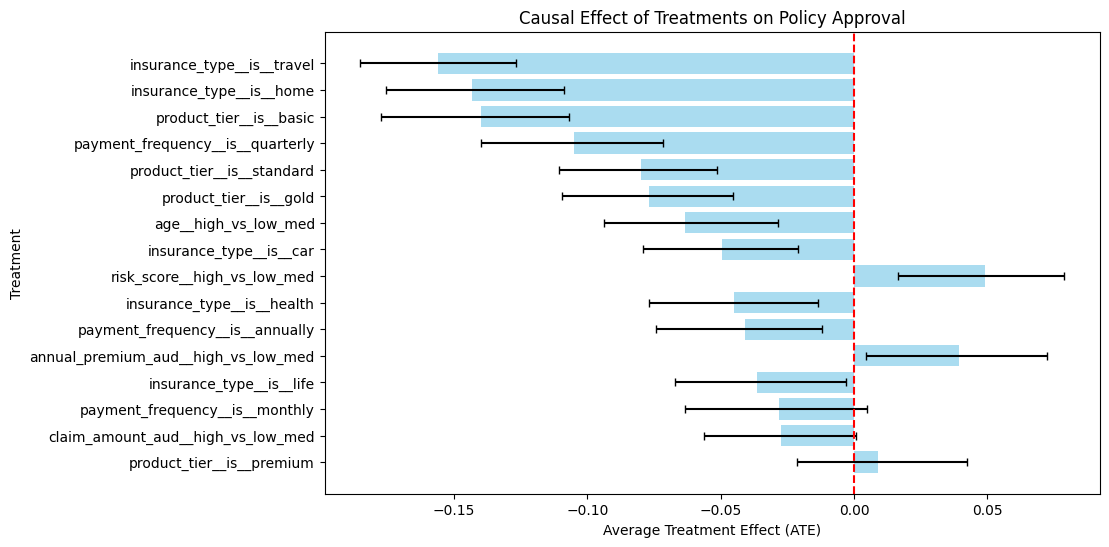

In [ ]:
import matplotlib.pyplot as plt
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Sort by absolute ATE magnitude
results_sorted = results_df.sort_values("ate", key=abs, ascending=False)

plt.figure(figsize=(10,6))
plt.barh(results_sorted["treatment"], results_sorted["ate"],
         xerr=[results_sorted["ate"] - results_sorted["ci_low"],
               results_sorted["ci_high"] - results_sorted["ate"]],
         alpha=0.7, color="skyblue", ecolor="black", capsize=3)

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Average Treatment Effect (ATE)")
plt.ylabel("Treatment")
plt.title("Causal Effect of Treatments on Policy Approval")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# 2. Counterfactual Explanation for a Policy
import numpy as np

# Pick one rejected policy (claim_status=0) from the counterfactual sample if available,
# otherwise sample from the original dataframe
rejected_cf = cf_df[cf_df[f"p_approve_if_{top_treatment}=1"] < 0.5] if cf_df is not None else None

if rejected_cf is not None and not rejected_cf.empty:
    sample_row_id = rejected_cf.iloc[0]["row_id"]
    sample = df.loc[[sample_row_id]]
    print("Original Rejected Policy from Counterfactual Sample:\n", sample)
    print("\nCounterfactual Probabilities for this policy:")
    display(cf_df[cf_df["row_id"] == sample_row_id])

else:
    # If no rejected policies in cf_df sample, or cf_df is None, sample from original df
    rejected_policies = df[y == 0]
    if not rejected_policies.empty:
        sample = rejected_policies.sample(1, random_state=42)
        print("Original Rejected Policy (sampled from data):\n", sample)
        # Calculate counterfactuals for this sampled policy
        if top_treatment and top_treatment in treatments:
             print(f"\nCalculating Counterfactual Probabilities for treatment: {top_treatment}")
             # Need to pass the single row dataframe to the counterfactual function
             cf_sample = outcome_model_counterfactuals(sample, y.loc[sample.index], top_treatment, sample_n=1)
             if cf_sample is not None:
                 display(cf_sample)
             else:
                 print("Could not calculate counterfactuals for this policy.")
        else:
            print("\nCannot calculate counterfactuals as top treatment is not defined or not in treatments.")
    else:
        print("No rejected policies found in the dataset.")

Original Rejected Policy from Counterfactual Sample:
          customer_name  age state insurance_type  annual_premium_aud  \
190  Barbara Hernandez   44   QLD         Travel             2834.19   

     claim_amount_aud claim_status policy_start_date policy_end_date  \
190          19366.95     Rejected        2023-10-04      2025-06-30   

    policy_number product_tier payment_frequency  risk_score  \
190    POL9514560        Basic          Annually        0.61   

                             email           phone  agent_name  
190  mendozamichael@johnson.net.au  (07)-0047-4799  Maria Cain  

Counterfactual Probabilities for this policy:


,row_id,p_approve_if_insurance_type__is__travel=1,p_approve_if_insurance_type__is__travel=0,delta_prob_1_minus_0
6,190,0.107955,0.121598,-0.013643


In [ ]:
# Try flipping key binary/categorical features one by one
improvements = []

if 'sample' in locals() and not sample.empty and 'model' in locals() and model is not None and 'top_treatment' in locals() and top_treatment in treatments: # Ensure sample, model, and top_treatment exist
    # Recalculate T_ based on the masked data used for the model
    mask = y.notna() & treatments[top_treatment].notna()
    T_ = treatments[top_treatment].loc[mask].astype(int)

    base_prob = model.predict_proba(pd.concat([sample.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                               T_.loc[sample.index].rename("t").reset_index(drop=True)], axis=1))[:,1][0]

    for col in sample.columns:
        if col != tgt: # Exclude the target column
            original_value = sample[col].iloc[0]
            temp = sample.copy()

            if col == top_treatment: # Check if it's the top treatment (our binary variable)
                # Flip the binary treatment
                flipped_value = 1 - original_value
                temp[col] = flipped_value

                # Need to recreate the treatment series for the model input for this single sample
                T_temp_sample = pd.Series([flipped_value], index=sample.index, name="t")

                new_prob = model.predict_proba(pd.concat([temp.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                                          T_temp_sample.reset_index(drop=True)], axis=1))[:,1][0]
                improvements.append((f"Flip '{col}' to {flipped_value}", new_prob - base_prob))

            elif col in treatments: # Other binary treatments (not the top treatment)
                 # Flip the binary treatment
                flipped_value = 1 - original_value
                temp[col] = flipped_value

                # The top treatment status remains the same for the model input
                T_temp_sample = pd.Series([T_.loc[sample.index].iloc[0]], index=sample.index, name="t")

                new_prob = model.predict_proba(pd.concat([temp.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                                          T_temp_sample.reset_index(drop=True)], axis=1))[:,1][0]
                improvements.append((f"Flip '{col}' to {flipped_value}", new_prob - base_prob))


            elif temp[col].dtype == "O": # Categorical feature (not a treatment)
                unique_cats = df[col].dropna().astype(str).str.strip().str.lower().unique().tolist()
                current_cat = str(original_value).strip().lower()
                if len(unique_cats) > 1:
                    for cat in unique_cats:
                        if cat != current_cat:
                            temp[col] = cat
                            # For non-treatment features, the 't' column in the model input remains the same
                            T_temp_sample = pd.Series([T_.loc[sample.index].iloc[0]], index=sample.index, name="t")
                            new_prob = model.predict_proba(pd.concat([temp.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                                                      T_temp_sample.reset_index(drop=True)], axis=1))[:,1][0]
                            improvements.append((f"Change '{col}' to '{cat}'", new_prob - base_prob))

            elif np.issubdtype(temp[col].dtype, np.number): # Numeric feature
                # Shift by 1 std dev up and down
                std_dev = df[col].std()
                if not pd.isna(std_dev) and std_dev > 0:
                    # Increase
                    temp_up = sample.copy()
                    temp_up[col] = original_value + std_dev
                    T_temp_sample = pd.Series([T_.loc[sample.index].iloc[0]], index=sample.index, name="t")
                    new_prob_up = model.predict_proba(pd.concat([temp_up.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                                                  T_temp_sample.reset_index(drop=True)], axis=1))[:,1][0]
                    improvements.append((f"Increase '{col}' by 1 StdDev ({original_value:.2f} -> {temp_up[col].iloc[0]:.2f})", new_prob_up - base_prob))

                    # Decrease
                    temp_down = sample.copy()
                    temp_down[col] = original_value - std_dev
                    T_temp_sample = pd.Series([T_.loc[sample.index].iloc[0]], index=sample.index, name="t")
                    new_prob_down = model.predict_proba(pd.concat([temp_down.drop(columns=[tgt], errors='ignore').reset_index(drop=True),
                                                                    T_temp_sample.reset_index(drop=True)], axis=1))[:,1][0]
                    improvements.append((f"Decrease '{col}' by 1 StdDev ({original_value:.2f} -> {temp_down[col].iloc[0]:.2f})", new_prob_down - base_prob))

    # Rank by improvement
    improvements_sorted = sorted(improvements, key=lambda x: x[1], reverse=True)

    print("\nCounterfactual Suggestions (what-if changes):")
    if improvements_sorted:
        for desc, delta in improvements_sorted[:10]: # Display top 10 suggestions
            if delta > 0:
                print(f" - {desc}: would increase approval probability by {delta:.3f}")
            else:
                 print(f" - {desc}: would decrease approval probability by {abs(delta):.3f}")
    else:
        print("No potential improvements found by flipping treatments or changing categorical/numeric features.")

else:
    print("ℹ️ Could not generate counterfactual suggestions. Ensure a rejected sample policy and the outcome model are available.")


Counterfactual Suggestions (what-if changes):
 - Change 'email' to 'ijohnson@yahoo.com': would increase approval probability by 0.053
 - Change 'email' to 'connieholmes@jones.edu': would increase approval probability by 0.043
 - Change 'phone' to '+61.3.8398.8637': would increase approval probability by 0.043
 - Change 'email' to 'christinarobles@hotmail.com': would increase approval probability by 0.043
 - Change 'phone' to '0404-369-705': would increase approval probability by 0.043
 - Change 'email' to 'melissa20@clark.biz': would increase approval probability by 0.043
 - Change 'phone' to '+61.2.5998.1096': would increase approval probability by 0.043
 - Change 'email' to 'utaylor@rodriguez-clarke.info': would increase approval probability by 0.043
 - Change 'phone' to '6832-5015': would increase approval probability by 0.043
 - Change 'email' to 'morganrenee@gmail.com': would increase approval probability by 0.042


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


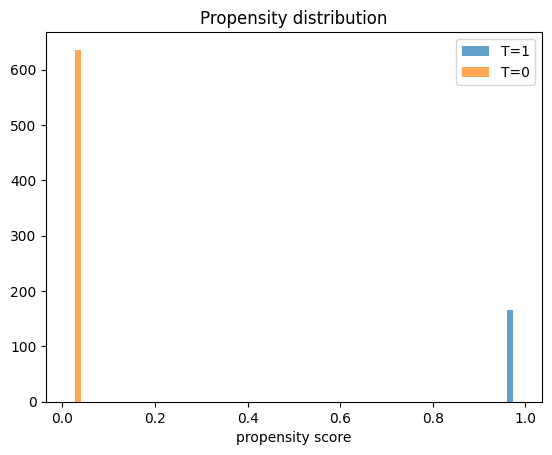

/tmp/ipython-input-3261261345.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([e[T_==1], e[T_==0]], labels=["T=1","T=0"]); plt.ylabel("propensity"); plt.show()


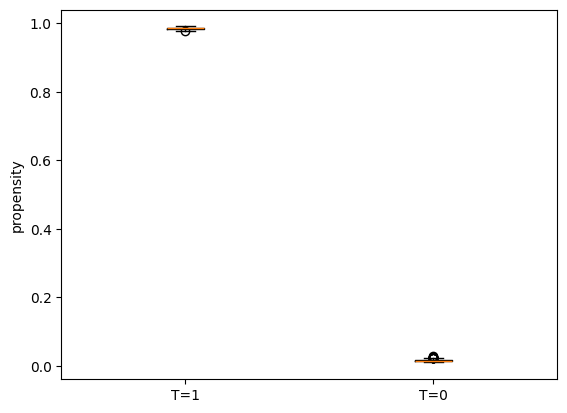

[('risk_score', np.float64(0.2021738577291026)),
 ('age', np.float64(0.12956646026263807)),
 ('claim_amount_aud', np.float64(0.056018164023322506)),
 ('annual_premium_aud', np.float64(-0.05476913970946388))]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


tname = "insurance_type__is__travel"
T = treatments[tname]           # 0/1 Int64
mask = y.notna() & T.notna()
X_raw = df.loc[mask].drop(columns=[tgt])
y_ = y.loc[mask].astype(int)
T_ = T.loc[mask].astype(int)

# 1) Propensity histogram (treated vs control)
prop_model = Pipeline([("pre", build_preprocessor(X_raw)), ("clf", LogisticRegression(max_iter=300, class_weight='balanced'))])
prop_model.fit(X_raw, T_)
e = prop_model.predict_proba(X_raw)[:,1]
plt.hist([e[T_==1], e[T_==0]], bins=30, label=['T=1','T=0'], stacked=False, alpha=0.7)
plt.legend(); plt.xlabel("propensity score"); plt.title("Propensity distribution"); plt.show()

# 2) Overlap (boxplot)
plt.boxplot([e[T_==1], e[T_==0]], labels=["T=1","T=0"]); plt.ylabel("propensity"); plt.show()

# 3) Standardized Mean Differences (SMD) pre-weighting for numeric covariates
num_cols = [c for c in X_raw.columns if np.issubdtype(X_raw[c].dtype, np.number)]
def smd(X, T, cols):
    out = {}
    for c in cols:
        m1 = X.loc[T==1, c].mean()
        m0 = X.loc[T==0, c].mean()
        sd = X[c].std()
        out[c] = (m1 - m0) / (sd if sd>0 else 1e-6)
    return out
smds = smd(X_raw, T_, num_cols)
# show largest imbalances
sorted(smds.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

In [ ]:
# e from propensity model above
e = np.clip(e, 1e-3, 1-1e-3)
w1 = T_/e                # weights for treated
w0 = (1-T_)/(1-e)        # weights for control

mu1 = np.sum(T_*y_/e) / np.sum(T_/e)
mu0 = np.sum((1-T_)*y_/(1-e)) / np.sum((1-T_)/(1-e))
ate_ipw = mu1 - mu0
print("IPTW ATE:", ate_ipw)

IPTW ATE: -0.057297529018609406
